### Lecture 2, f0 detection using Essentia - Melodia:

In this example, we demonstrate use of the predominant melody extraction function of Essentia, discuss the influence of analysis parameter choice on the estimated pitch info and also demonstrate use of [mir_eval](https://github.com/craffel/mir_eval) library to evaluate its performance. 

There is no student version of this notebook

In [1]:
import os
from essentia import *
from essentia.standard import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window

In [2]:
soundsDir = '../data/baris/'
fileName = os.path.join(soundsDir, 'eh.wav')
fs = 44100
windowSize=4096
hopSize=1024
run_predominant_melody = PitchMelodia(guessUnvoiced = True,
                                      frameSize = windowSize,
                                      hopSize = hopSize,
                                      maxFrequency = 2000,
                                      minFrequency = 50,
                                      sampleRate = fs);

# Load audio file, apply equal loudness filter, and compute predominant melody
x = MonoLoader(filename = fileName, sampleRate = fs)()
#x = EqualLoudness()(x)
f0, confidence = run_predominant_melody(x)

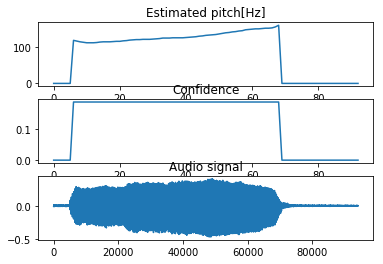

In [3]:
#Plotting estimated pitch, confidence with audio
f, axarr = plt.subplots(3)
axarr[0].plot(f0)
axarr[0].set_title('Estimated pitch[Hz]')
axarr[1].plot(confidence)
axarr[1].set_title('Confidence')
axarr[2].plot(x)
axarr[2].set_title('Audio signal')
plt.show()

In [4]:
#Saving estimated values to file
fileNameF0 = fileName.replace('.wav','.f0_preDomMel.txt')
startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)
with open(fileNameF0, 'w') as f:
    for k in range(startIndexes.size):
        time = (startIndexes[k] + windowSize / 2) / fs
        f.write(str(time) + '\t' + str(f0[k]) + '\n')

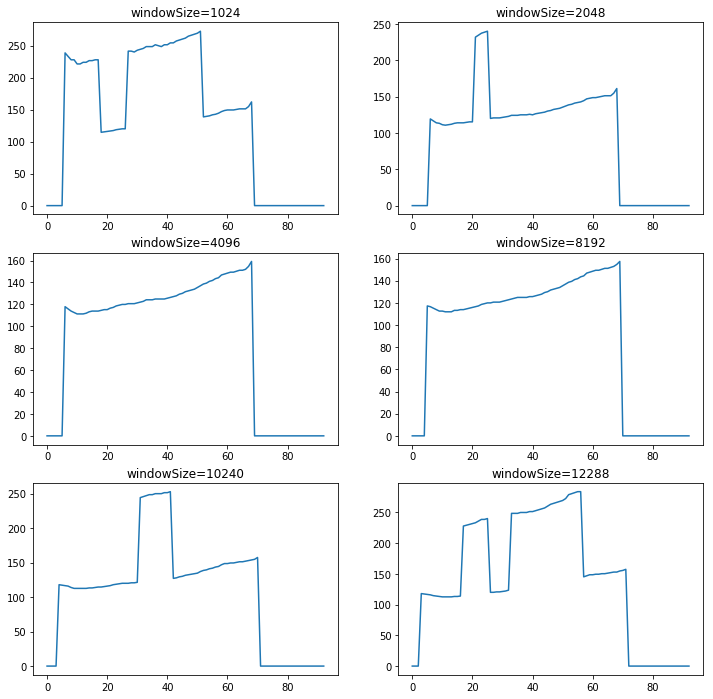

In [5]:
#Demonstrating influence of parameters in estimation
winSizeValues = np.array([1,2,4,8,10,12])*1024
numFrm2plot = len(winSizeValues)
plt.figure(figsize = (12, numFrm2plot * 2))
plotInd = 1
for windowSize in winSizeValues:
    run_predominant_melody = PitchMelodia(guessUnvoiced = True, frameSize = int(windowSize), hopSize = hopSize, sampleRate = fs);
    f0, confidence = run_predominant_melody(x)
    plt.subplot(numFrm2plot / 2, 2, plotInd)
    plt.plot(f0)
    plt.title('windowSize=' + str(windowSize))
    plotInd += 1

### Let's now evaluate Essentia's performance on a file from a Mirex test dataset:

We will use [mir-eval](https://github.com/craffel/mir_eval) Python library ([documentation](http://craffel.github.io/mir_eval/)) presented in:
Colin Raffel, Brian McFee, Eric J. Humphrey, Justin Salamon, Oriol Nieto, Dawen Liang, and Daniel P. W. Ellis, ["mir_eval: A Transparent Implementation of Common MIR Metrics"](http://colinraffel.com/publications/ismir2014mir_eval.pdf), Proceedings of the 15th International Conference on Music Information Retrieval, 2014.

File resource: https://labrosa.ee.columbia.edu/projects/melody/ 

In [6]:
import mir_eval
dataFolder = '../data/melody/mirex05TrainFiles/'

#Reading ground-truth
ref_time, ref_freq = mir_eval.io.load_time_series(dataFolder + 'train01REF.txt')

#Running Essentia predominant melody extraction and saving to an output file
hopSize = 441#10 miliseconds
run_predominant_melody = PitchMelodia(guessUnvoiced = True, frameSize = int(windowSize), hopSize = hopSize,sampleRate=fs)
x = MonoLoader(filename = dataFolder+'train01.wav', sampleRate = fs)()
x = EqualLoudness()(x)
f0, confidence = run_predominant_melody(x)
startIndexes = np.arange(0, x.size-windowSize,hopSize, dtype=int)
with open(dataFolder + 'train01MEL.txt', 'w') as f:
    for k in range(startIndexes.size):
        f.write(str(k*0.01) + '\t' + str(f0[k]) + '\n')

#Re-reading Essentia estimation results
est_time, est_freq = mir_eval.io.load_time_series(dataFolder + 'train01MEL.txt')

#Running evaluation and ptinting
scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq)
for score in scores:
    print(score,'\t',scores[score])

Voicing Recall 	 0.984943538269
Voicing False Alarm 	 0.679577464789
Raw Pitch Accuracy 	 0.816813048934
Raw Chroma Accuracy 	 0.822459222083
Overall Accuracy 	 0.643908421913
